# Telco Churn Rate <a class="tocSkip">

## imports <a class="tocSkip">

In [1]:
# import pandas as pd 
import numpy as np 

import matplotlib.pyplot as plt 
import seaborn as sns
import os

from sklearn.model_selection import train_test_split
import sklearn.preprocessing
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression

from scipy import stats
import re

import acquire as acq
import explore as exp
import prepare as p
import model as m

from pathlib import Path  

import warnings
warnings.filterwarnings("ignore")

# Goal: <a class="tocSkip">

* Isolate the key drivers for cusomer churn at Telco
* Use the key drivers to develop a M.L model to accurately predict customer churn
* Create a report that is easy to interpret, follow, and repeat.

# Acquire <a class="tocSkip">

* The data was pulled fromt the Sequel Ace database, through an acquire file function.
* Data was acquire in December and was prepped and cleaned.
* Dataframe is built of 31 columns and 7010 rows after being scrubbed. ( 7032, 20 before scrub and cleaning)
* Each observation is a current or past customer of the company Telco
* Each column is a feature that will correspond to the customer. Read the ReadMe file in github for descriptions.

In [2]:
# gathering my data and cleaning up
df = acq.get_telco_data(acq.get_connection)

# Prepare <a class="tocSkip">

* Duplicate and null Columns were dropped
* Whitespace were stripped
* Data Types were changed 
* Whitespace were stripped
* Data Types were changed 
* Dummy Variables were created for modeling
* Redundant columns were dropped for a clean data frame

In [3]:
# dropping duplicates, nulls, creating dummies,   
# dropping redundant columns
df = p.prep_telco(df)

In [4]:
# splitting data into train, validate, and test data frames
train, validate, test = acq.split_data(df)

# Explore <a class="tocSkip">

##  How often do customers churn?  <a class="tocSkip">

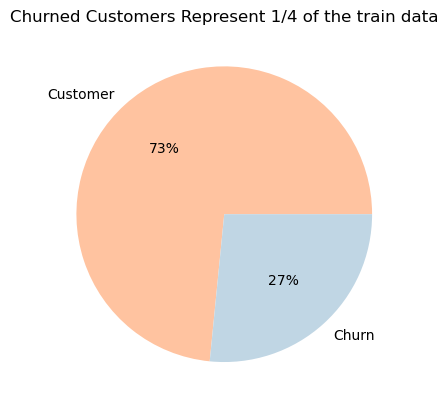

In [5]:
# get churn rates
exp.get_churn_rate(train)

* We are focusing on the 27% of customers who are choosing to leave us. Who are they and why are they leaving

#  Initial Questions <a class="tocSkip">

## Do people who use tech support churn more often? <a class="tocSkip">

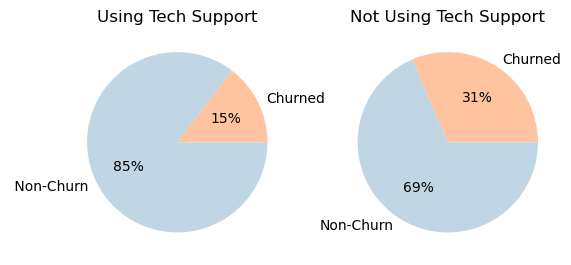

In [6]:
# get churn rate compared to tech support usage
exp.get_tech_churn(train)

* Churn rating is 16% lower in cases where the customer used tech support.

### Chi-square test is need to investigate relevance / correlation between churn rate and tech support <a class="tocSkip">

* confidence level of 95%
* alpha set to .05

In [7]:
# Ho: Churn rate and Tech Support usage are independent of one another. 

# Ha: Churn rate and Tech Support usage are related. 


In [8]:
# get chi test results
exp.get_chi_tech(train)

chi^2 = 115.9927
p     = 4.7705836754113494e-27


* The p-value is greater than the alpha. This is some evidence to support that the two have some relationship.
* The difference in observed vs expected leads me to believe this will be a good feature for a model's accuracy

## Do people who pay more PER month churn more often? <a class="tocSkip">

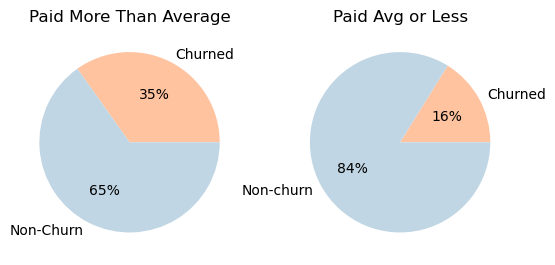

In [9]:
# get pie chart churn rate compared to monthly payment
exp.get_month_churn(train)

* Customers who paid more than the average monthly payment churned 18% more.

### A T-test will help determine a significant difference between the mean off those who paid above the average amount compared to those who paid less. <a class="tocSkip">

* confidence interval of 95%
* alpha is .05

In [10]:
# Ho: The mean difference in churn rating of customers who paid more than average is not significantly different from the mean of those who paid the average amount or less.
# Ha: The mean difference in churn rating of customers who paid more than average is significantly different from the mean of those who paid the average amount or less.

In [11]:
# get t test results
exp.get_t_monthly(train)

t = 13.1249
p = 1.5469518022614562e-36
We can reject the null hypothesis


* Rejecting the null hypothesis, we find that there is a significant difference in the two groups means. Based on this, it might be benificial to use "Monthly Charges" during modeling.

## Do senior citizens churn more than non-senior citizens? <a class="tocSkip">

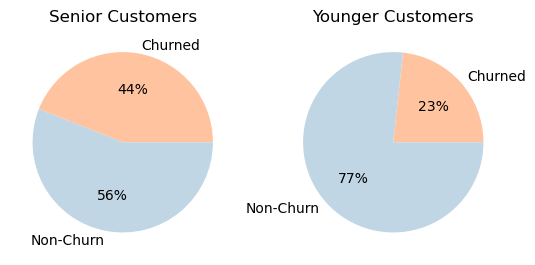

In [12]:
# get pie chart churn rate compared to senior citizen status
exp.get_senior_churn(train)

* Senior customers, even though they make up less of the population, churn 18% more than younger customer.

### A T-test will help determine a significant difference between the average churn rate of senior customers compared to cusomters who are younger. <a class="tocSkip">


* confidence innterval of 95%
* alpha is 0.5

In [13]:
# Ho: The average churn rate difference in senior customers is not significantly different to customers who are younger.
# Ha: The average churn rate difference in senior customers is significantly different to customers who are younger.

In [14]:
# get t test results
exp.get_t_senior(train)

t = 10.9158
p = 2.3798915960038116e-27
We can reject the null hypothesis


* Rejecting the null hypothesis, we find that there is a significant difference in the two groups means. Based on this, it might be benificial to use "Senior Citizen" during modeling.

## Do customers with longer tenure churn more than customers with shorter tenure?<a class="tocSkip">

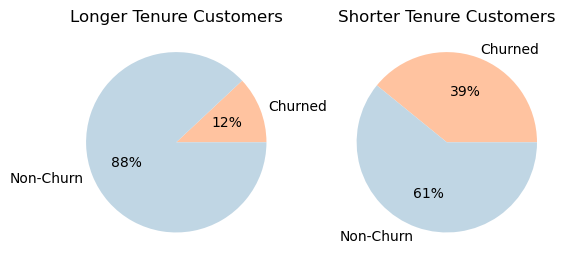

In [15]:
# get pie chart churn rate compared to customers tenure
exp.get_tenure_rate(train)

* Customers who have a longer tenure churned 26% less than customers who have had an average tenure or shorter

### A T-test will help determine a significant difference between the average churn rate of long tenure customers compared to cusomters who have a shorter tenure. <a class="tocSkip">

* confidence interval of 95%
* alpha is .05

In [16]:
# Ho: The average churn rate difference in longer tenure customers is not significantly different to customers who have a shorter tenure.
# Ho: The average churn rate difference in longer tenure customers is significantly different to customers who have a shorter tenure.

In [17]:
# get t test results
exp.get_t_tenure(train)

t = -24.2622
p = 2.659774021665938e-121
We can reject the null hypothesis


* Rejecting the null hypothesis, we find that there is a significant difference in the two groups means. Based on this, it might be benificial to use "Tenure" during modeling.

# Exploration Summary <a class="tocSkip">

* Not using "Tech Support" seems to influence a churn rate.
* Higher "Monthly Charges" seemed to be a driver in churn rate. 
* "Senior Citizens" group seemed to be a driver higher of churn rate
* Shorter " Tenure" seemed to be a driver of higher churn rate

* I believe there could be othere causes of churn but for the moment these current features will be suffice for classification modeling

# Modeling <a class="tocSkip">

* Accuracy will be the main evaluation metric
* Churn makes up 27% of train data

* Baseline model prediction will be "Non-Churn" or 73% and the objective is to create a model that will out perfrom this.


* The feature chosen for the models are those that correspond to the questions above.  
( 'Tech Support', 'Monthly Charge', "Senior Citizen", "Tenure")

In [18]:
# prep data for modeling, return all of data sets and splits.
train_x, validate_x, test_x, train_y, validate_y, test_y = m.model_prep_stmt(train,validate,test)

# Top Models <a class="tocSkip">

## Random Forest  <a class="tocSkip">

### Random Forest (max depth = 5) <a class="tocSkip">

In [19]:
## # get random forest results
m.get_forest(train_x, validate_x, train_y, validate_y,5)

Random Forest
Accuracy of Random Forest on train is 0.808229616459233
Accuracy of Random Forest on validate is 0.783175355450237


* Random Forest accuracy is out performing baseline
* Overfitting does not seem to be an issue here

### Random Forest (max depth = 3) <a class="tocSkip">

In [20]:
## # get random forest results
m.get_forest(train_x, validate_x, train_y, validate_y,3)

Random Forest
Accuracy of Random Forest on train is 0.7962915925831852
Accuracy of Random Forest on validate is 0.7790284360189573


* Random Forest accuracy is out performing baseline
* Overfitting does not seem to be an issue here

## Decision Tree <a class="tocSkip">

### Decision Tree (max depth = 5) <a class="tocSkip">

In [21]:
# get random forest results
m.get_tree(train_x, validate_x, train_y, validate_y,5)

Decision Tree
Accuracy of Decision Tree on train data is 0.7980695961391923
Accuracy of Decision Tree on validate data is 0.7890995260663507


* Decision Tree accuracy is out performing baseline
* Overfitting does not seem to be an issue here

## Model Wrap <a class="tocSkip">

* These models out performed the baseline on both train and validate
* The decision tree with a depth of 5 performed comparable to second place but showed signs of overfitting
* The random forest with a depth of 5 is approved for production as an mvp.

# Best Performance <a class="tocSkip">

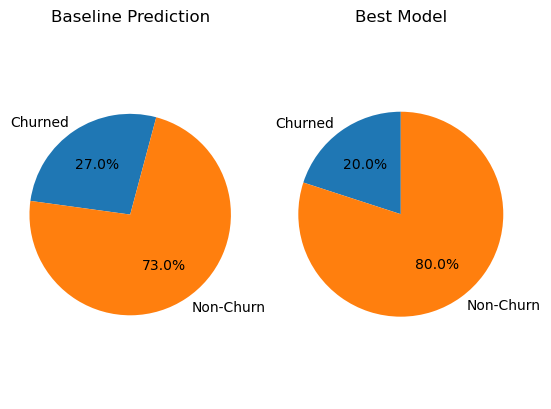

In [22]:
# pie chart for baseline comparison against best model
exp.get_compare()

# Conclusion <a class="tocSkip">

## Exploration <a class="tocSkip">

* Customers churn occurs 1/4 of observations
* Customers who do not use tech support churn 16% more.
* Customers who are paying more than the monthly average churn 18% more.
* Older Customers have more reasons to churn than younge customers 18% more.
* Customerser who have a longer tenure churn 26% less.


## Modeling <a class="tocSkip">

* KNN model had the worst performance compared to other models, issues overfitting.


# Recommendation <a class="tocSkip">

* Telco could look into pushing tech support to customers   
  or futher investigations.
* Telco could look into promotions,sales,bundles  
  or other ways to give customers who pay more incentives to stay.
* Telco could look into finding ways to be senior friendly.
* Telco could look into why customers have an incentive to stay for so long.  
  (rewards or long time customer benefits)

# Next Steps <a class="tocSkip">

* Create new features that may have a relationship.  
  (Are senior citizen using tech support)
  
* Further work with model features and settings to create more accurate models.
